In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
dir_pipeline = Path(".").resolve().parents[1]
dir_5 = dir_pipeline / "5_optimisation"
dir_6 = dir_pipeline / "6_evaluation"

dir_out = Path(".").resolve() / "RuntimesFig7"
dir_out.mkdir(exist_ok=True)

In [2]:
NOISE_PARAMETER_IDS = ["sd_pSTAT5A_rel", "sd_pSTAT5B_rel", "sd_rSTAT5A_rel"]

def load_exp_summary(dir_exp_output: Path):
    summary = pd.read_csv(dir_exp_output / "experiment_summary.csv")
    # drop the runs that did not finish
    summary = summary.dropna(subset=NOISE_PARAMETER_IDS)
    return summary

scenarios = [
    'boehm_papa_export_kinetic',
    'boehm_observable_ab_ratio',
    'boehm_papb_differential',
    'boehm_export_augmented',
]

In [3]:
# import the optimisation summaries

experiments_names = [
    '2024_08_01_Boehm_papa_export_kinetic',
    '2024_08_11_Boehm_observable_ab_ratio',
    '2024_08_21_Boehm_papb_differential',
    '2024_08_27_Boehm_export_augmented',
    '2024_11_14_Boehm_export_augmented_preopt',
    '2024_11_20_Boehm_export_augmented_preopt',
    '2024_11_20_Boehm_observable_ab_ratio',
]

dfs = [load_exp_summary(dir_5 / n) for n in experiments_names]
df = pd.concat(dfs)

# calc total run time
df["runtime_total"] = df["runtime_ADAM_in_min"] + df["runtime_BFGS_in_min"]

In [4]:
map_labels = {
    'boehm_papa_export_kinetic': 'kinetic',
    'boehm_observable_ab_ratio': 'observable',
    'boehm_papb_differential': 'differential',
    'boehm_export_augmented': 'augmented',
}
df['short_label'] = df["problem_name"].map(map_labels)

problem_labels = ['kinetic', 'differential', 'augmented', 'observable']

In [5]:
df["short_label"].value_counts()

short_label
observable      29996
augmented        3988
differential     2996
kinetic          2717
Name: count, dtype: int64

### Compare run times between UDE Scenarios

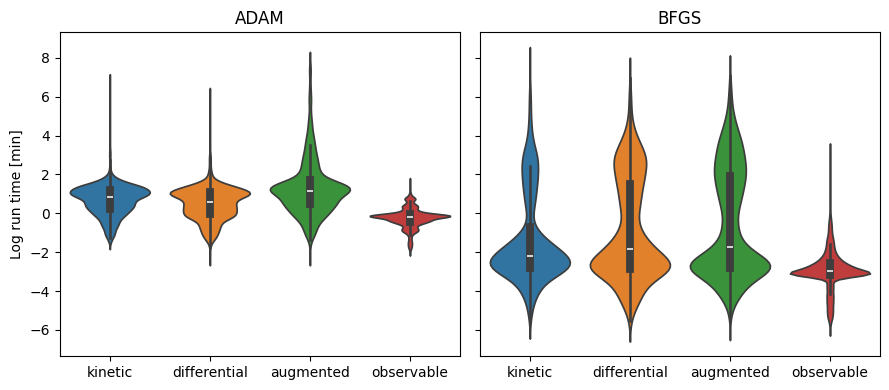

In [6]:
# Run times in violinplots, per optimiser 
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)

for ax, optimiser_name in zip(axes, ["ADAM", "BFGS"]):
    d = {s: np.log(df.query("short_label == @s")[f"runtime_{optimiser_name}_in_min"].values) for s in problem_labels}
    sns.violinplot(d, ax=ax)
    # ax.set_yscale("log")
    ax.set_ylabel("Log run time [min]")
    ax.set_title(optimiser_name)

fig.tight_layout()
fig.savefig(dir_out / "runtime_violins_optimisers.svg")

/tmp/ipykernel_1157618/1205298172.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(f"{i}-{l}" for i, l in zip(np.arange(1, 5), [label._text for label in ax.get_xticklabels()]))


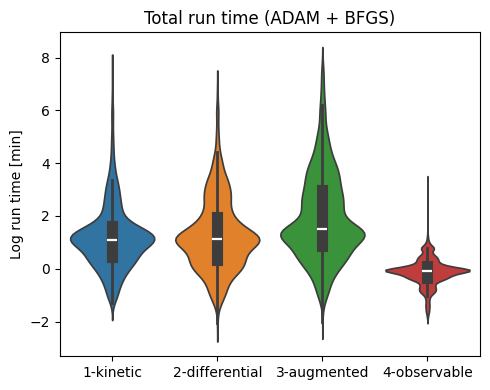

In [7]:
# Run times in violinplots, combined
fig, ax = plt.subplots(figsize=(5, 4), sharey=True)

d = {s: np.log(df.query("short_label == @s")[f"runtime_total"].values) for s in problem_labels}
sns.violinplot(d, ax=ax, inner_kws=dict(box_width=8, whis_width=2))
# ax.set_yscale("log")
ax.set_ylabel("Log run time [min]")
ax.set_title("Total run time (ADAM + BFGS)")
ax.set_xticklabels(f"{i}-{l}" for i, l in zip(np.arange(1, 5), [label._text for label in ax.get_xticklabels()]))

fig.tight_layout()
fig.savefig(dir_out / "runtime_violins_total.svg")

short_label
augmented       4.564463
differential    3.035229
kinetic         2.933058
observable      0.909430
Name: runtime_total, dtype: float64


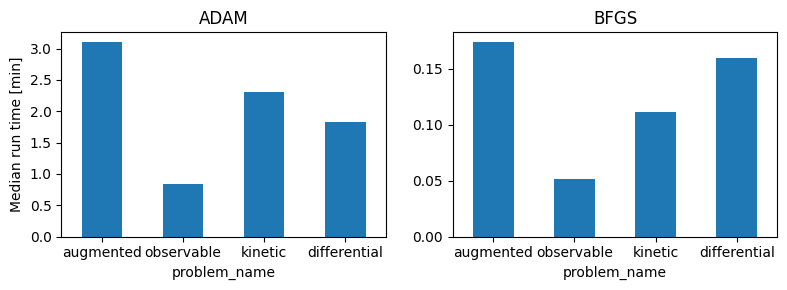

In [8]:
# Median run times
print(df.groupby(by="short_label")[f"runtime_total"].median())

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), sharey=False)

for ax, optimiser_name in zip(axes, ["ADAM", "BFGS"]):
    df.groupby(by="problem_name")[f"runtime_{optimiser_name}_in_min"].median().plot.bar(ax=ax)
    xticklabels = [map_labels[i._text] for i in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels, rotation=0)
    # ax.set_yscale("log")
    ax.set_title(optimiser_name)

axes[0].set_ylabel("Median run time [min]")
fig.tight_layout()
fig.savefig(dir_out / "runtime_medians_individual.svg")

/tmp/ipykernel_1157618/324256096.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


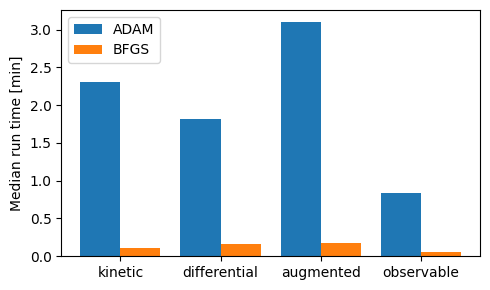

In [9]:
optimiser_names = ["ADAM", "BFGS"]
x = np.arange(len(scenarios))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(5, 3))

for optimiser_name in optimiser_names:
    medians = [
        df.query("short_label == @s")[
            f"runtime_{optimiser_name}_in_min"
        ].median() for s in problem_labels
    ]
    offset = width * multiplier
    rects = ax.bar(x + offset, medians, width, label=optimiser_name)
    # ax.bar_label(rects, padding=3, fmt="%.2f")
    multiplier += 1

ax.set_ylabel('Median run time [min]')
ax.set_xticks(x + width/2, problem_labels)
ax.legend(loc='upper left')

fig.tight_layout()
fig.savefig(dir_out / "runtime_medians.svg")

/tmp/ipykernel_1157618/2653462273.py:19: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


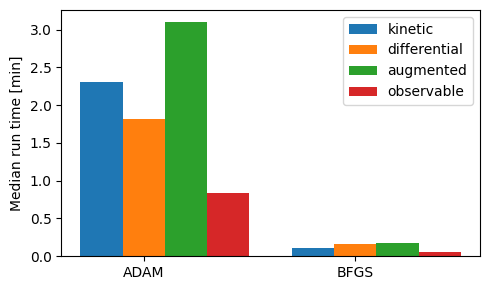

In [10]:
optimiser_names = ["ADAM", "BFGS"]
x = np.arange(2)  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(5, 3))

for s in problem_labels:
    medians = [df.query("short_label == @s")[f"runtime_{optimiser_name}_in_min"].median() for optimiser_name in optimiser_names]
    offset = width * multiplier
    rects = ax.bar(x + offset, medians, width, label=s)
    # ax.bar_label(rects, padding=3, fmt="%.2f")
    multiplier += 1

ax.set_ylabel('Median run time [min]')
ax.set_xticks(x + width, optimiser_names)
ax.legend(loc='upper right')

fig.tight_layout()
# fig.savefig(dir_out / "runtime_medians.svg")

short_label
augmented       42.539839
differential    13.375730
kinetic         12.337942
observable       0.988339
Name: runtime_total, dtype: float64


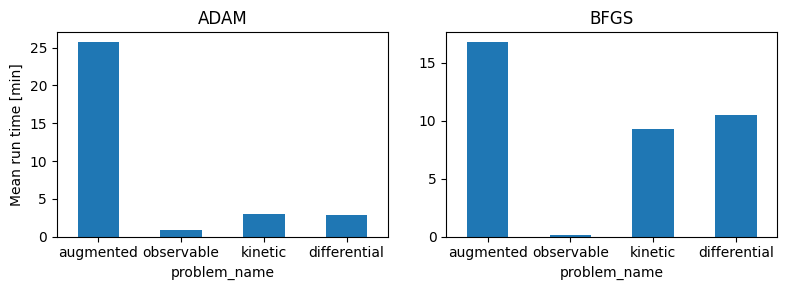

In [11]:
# Mean run times
print(df.groupby(by="short_label")[f"runtime_total"].mean())

fig, axes = plt.subplots(ncols=2, figsize=(8, 3), sharey=False)

for ax, optimiser_name in zip(axes, ["ADAM", "BFGS"]):
    df.groupby(by="problem_name")[f"runtime_{optimiser_name}_in_min"].mean().plot.bar(ax=ax)
    xticklabels = [map_labels[i._text] for i in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels, rotation=0)
    # ax.set_yscale("log")
    ax.set_title(optimiser_name)

axes[0].set_ylabel("Mean run time [min]")
fig.tight_layout()
fig.savefig(dir_out / "runtime_means_individual.svg")

/tmp/ipykernel_1157618/3333299328.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


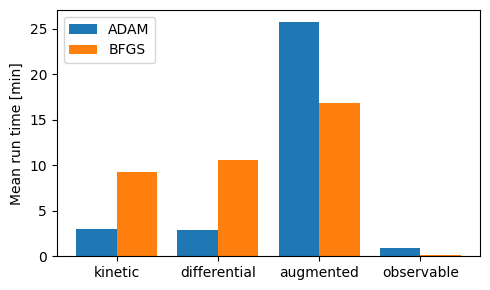

In [12]:
optimiser_names = ["ADAM", "BFGS"]
x = np.arange(len(scenarios))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(5, 3))

for optimiser_name in optimiser_names:
    means = [
        df.query("short_label == @s")[
            f"runtime_{optimiser_name}_in_min"
        ].mean() for s in problem_labels
    ]
    offset = width * multiplier
    rects = ax.bar(x + offset, means, width, label=optimiser_name)
    # ax.bar_label(rects, padding=3, fmt="%.2f")
    multiplier += 1

ax.set_ylabel('Mean run time [min]')
ax.set_xticks(x + width/2, problem_labels)
ax.legend(loc='upper left')
fig.tight_layout()
fig.savefig(dir_out / "runtime_means.svg")

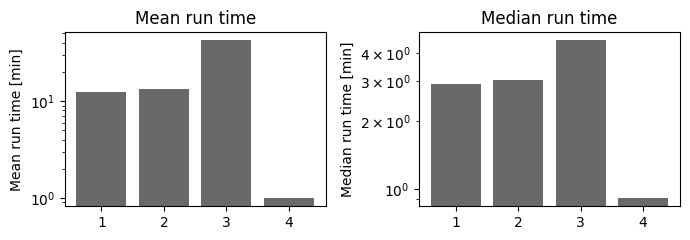

In [13]:
# Combined run times, mean and median
fig, axes = plt.subplots(ncols=2, figsize=(7, 2.5), sharey=False)

# mean
ax = axes[0]
means = df.groupby(by="short_label")[f"runtime_total"].mean()
ax.bar(np.arange(1, 5), [means[p] for p in problem_labels], color="dimgrey")
ax.set_title("Mean run time")
ax.set_ylabel("Mean run time [min]")
ax.set_yscale("log")

# median
ax = axes[1]
medians = df.groupby(by="short_label")[f"runtime_total"].median()
ax.bar(np.arange(1, 5), [medians[p] for p in problem_labels], color="dimgrey")
ax.set_title("Median run time")
ax.set_ylabel("Median run time [min]")
ax.set_yscale("log")

fig.tight_layout()
fig.savefig(dir_out / "runtime_total_individual.svg", transparent=True)

### Run times by regularisation

In [14]:
dfreg = df.query("problem_name == 'boehm_observable_ab_ratio'").copy()

# add reg bins
bins = [-1, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
labels_regbins = ["0", "<0.01", "<0.1", "<1", "<10", "<100", "<1000"]
dfreg["regbin"] = pd.cut(dfreg['λ_reg'], bins=bins, labels=labels_regbins)

dfreg['regbin'].value_counts()

regbin
0        6098
<1000    3990
<1       3990
<100     3988
<0.1     3988
<0.01    3971
<10      3971
Name: count, dtype: int64

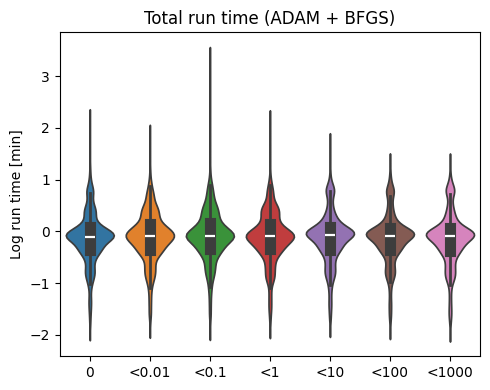

In [15]:
fig, ax = plt.subplots(figsize=(5, 4), sharey=True)

d = {r: np.log(dfreg.query("regbin == @r")[f"runtime_total"].values) for r in labels_regbins}
sns.violinplot(d, ax=ax, inner_kws=dict(box_width=8, whis_width=2))
ax.set_ylabel("Log run time [min]")
ax.set_title("Total run time (ADAM + BFGS)")

fig.tight_layout()
fig.savefig(dir_out / "runtime_violins_total_byreg.svg")

/tmp/ipykernel_1157618/664973754.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = dfreg.groupby(by="regbin")[f"runtime_total"].mean()
/tmp/ipykernel_1157618/664973754.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = dfreg.groupby(by="regbin")[f"runtime_total"].median()


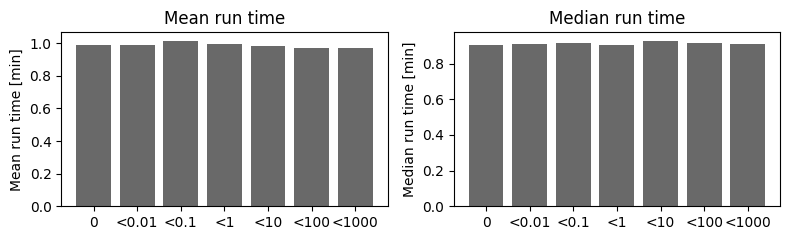

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 2.5), sharey=False)

# mean
ax = axes[0]
means = dfreg.groupby(by="regbin")[f"runtime_total"].mean()
ax.bar(labels_regbins, [means[r] for r in labels_regbins], color="dimgrey")
ax.set_title("Mean run time")
ax.set_ylabel("Mean run time [min]")

# median
ax = axes[1]
medians = dfreg.groupby(by="regbin")[f"runtime_total"].median()
ax.bar(labels_regbins, [medians[r] for r in labels_regbins], color="dimgrey")
ax.set_title("Median run time")
ax.set_ylabel("Median run time [min]")

fig.tight_layout()
fig.savefig(dir_out / "runtime_total_individual_byreg.svg", transparent=True)